In [22]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/jun_21_dec_24_w_metadata_predict_df.csv",
                         parse_dates=['sample_dt'],
                         index_col=0)

# Load sentinel features
sentinel_features = pd.read_csv("../data/gcs/train/sentinel2/jun_21_dec_24_w_metadata.csv").drop(columns=['system:index', '.geo'])
predict_df = predict_df.merge(sentinel_features, on='sample_idx')

num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'geometry', 'sample_idx', 'sample_dt', 'prev_sample_dt'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

# Get parameters for classification problem
# predict_df['month'] = predict_df['sample_dt'].dt.month # Not including for now since last year had odd trend I don't want attributed to month

predict_df = predict_df.drop(columns=['ammonia_mg_per_L', 'ph', 'turbidity_cm'])
winkler_df = predict_df[predict_df['do_winkler']].copy()       

### Check correlations with detrending

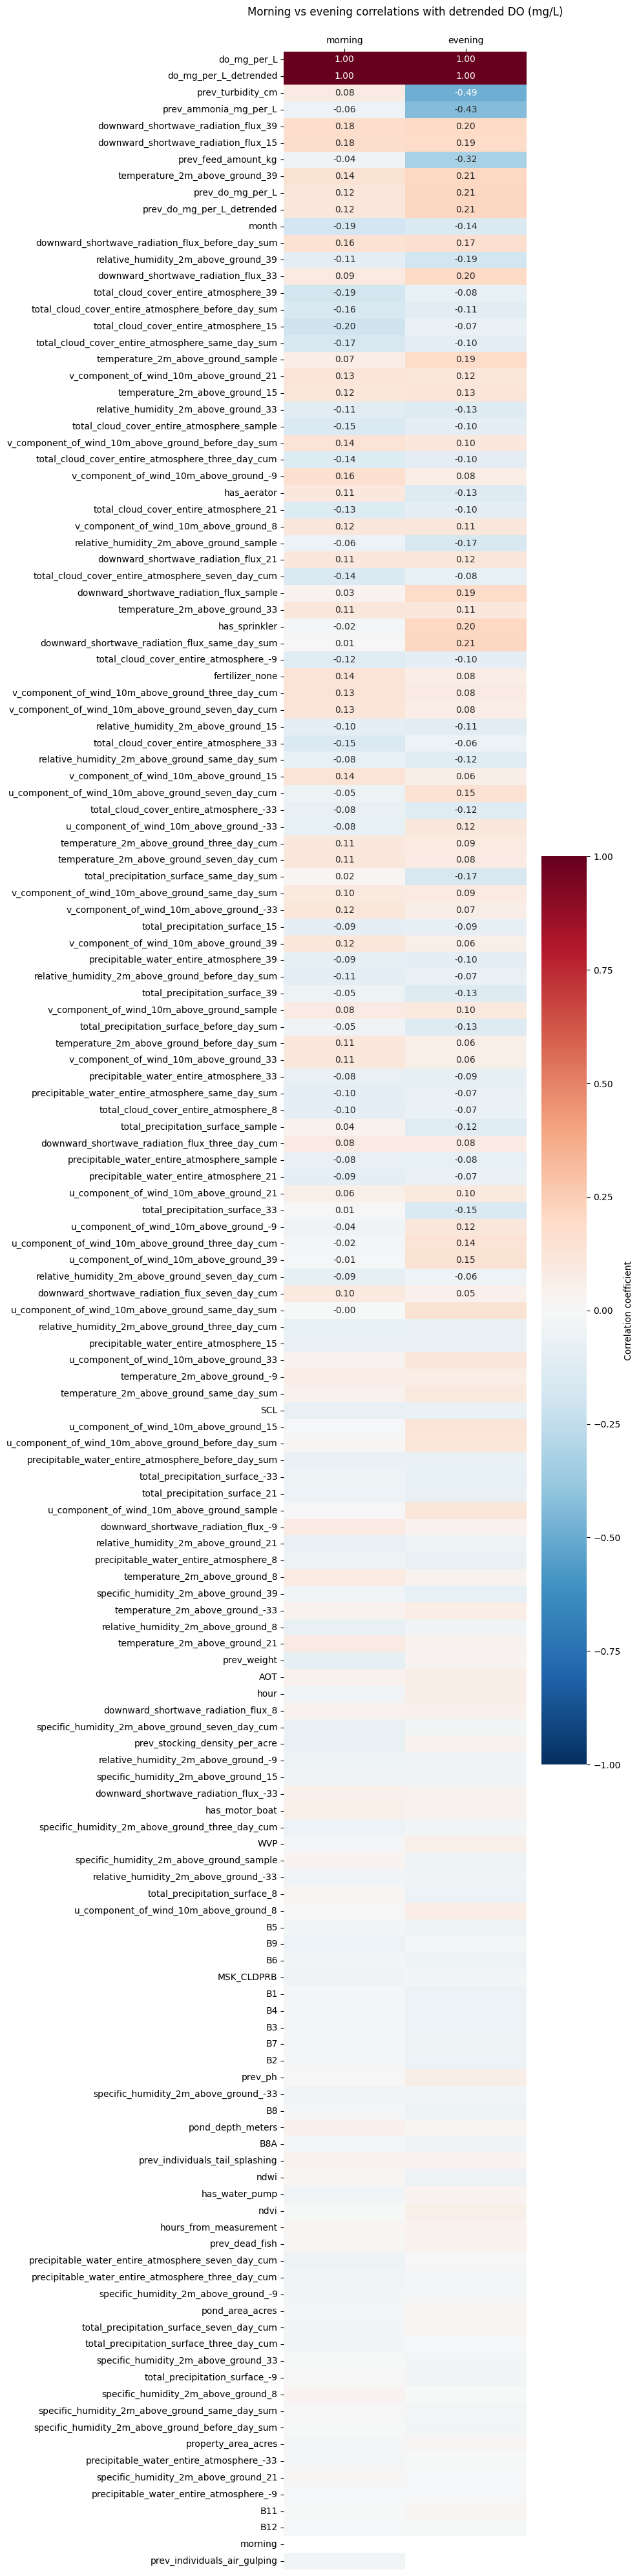

In [24]:
# Create copy of winkler_df and group by morning to detrend DO values
winkler_df = winkler_df.copy()
diurnal_means = winkler_df.groupby(['morning'])['do_mg_per_L'].transform('mean')
winkler_df['do_mg_per_L_detrended'] = winkler_df['do_mg_per_L'] - diurnal_means
winkler_df['prev_do_mg_per_L_detrended'] = winkler_df['prev_do_mg_per_L'] - diurnal_means

# Calculate correlations separately for morning and evening
numeric_cols = winkler_df.select_dtypes(include=['float64', 'int64', 'bool']).columns.drop(['do_winkler'])

morning_corr = winkler_df[winkler_df['morning']][numeric_cols].corr()['do_mg_per_L_detrended']
evening_corr = winkler_df[~winkler_df['morning']][numeric_cols].corr()['do_mg_per_L_detrended']

# Combine correlations into a DataFrame
corr_comparison = pd.DataFrame({
    'morning': morning_corr,
    'evening': evening_corr
})
corr_comparison['total'] = corr_comparison['morning'].abs() + corr_comparison['evening'].abs()
corr_comparison = corr_comparison.sort_values('total', ascending=False).drop('total', axis=1)

# Create heatmap
plt.figure(figsize=(10, 40))
sns.heatmap(corr_comparison,
            vmin=-1,
            vmax=1,
            cmap='RdBu_r',
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlation coefficient'})
plt.title('Morning vs evening correlations with detrended DO (mg/L)', pad=40)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.tight_layout()
plt.show()


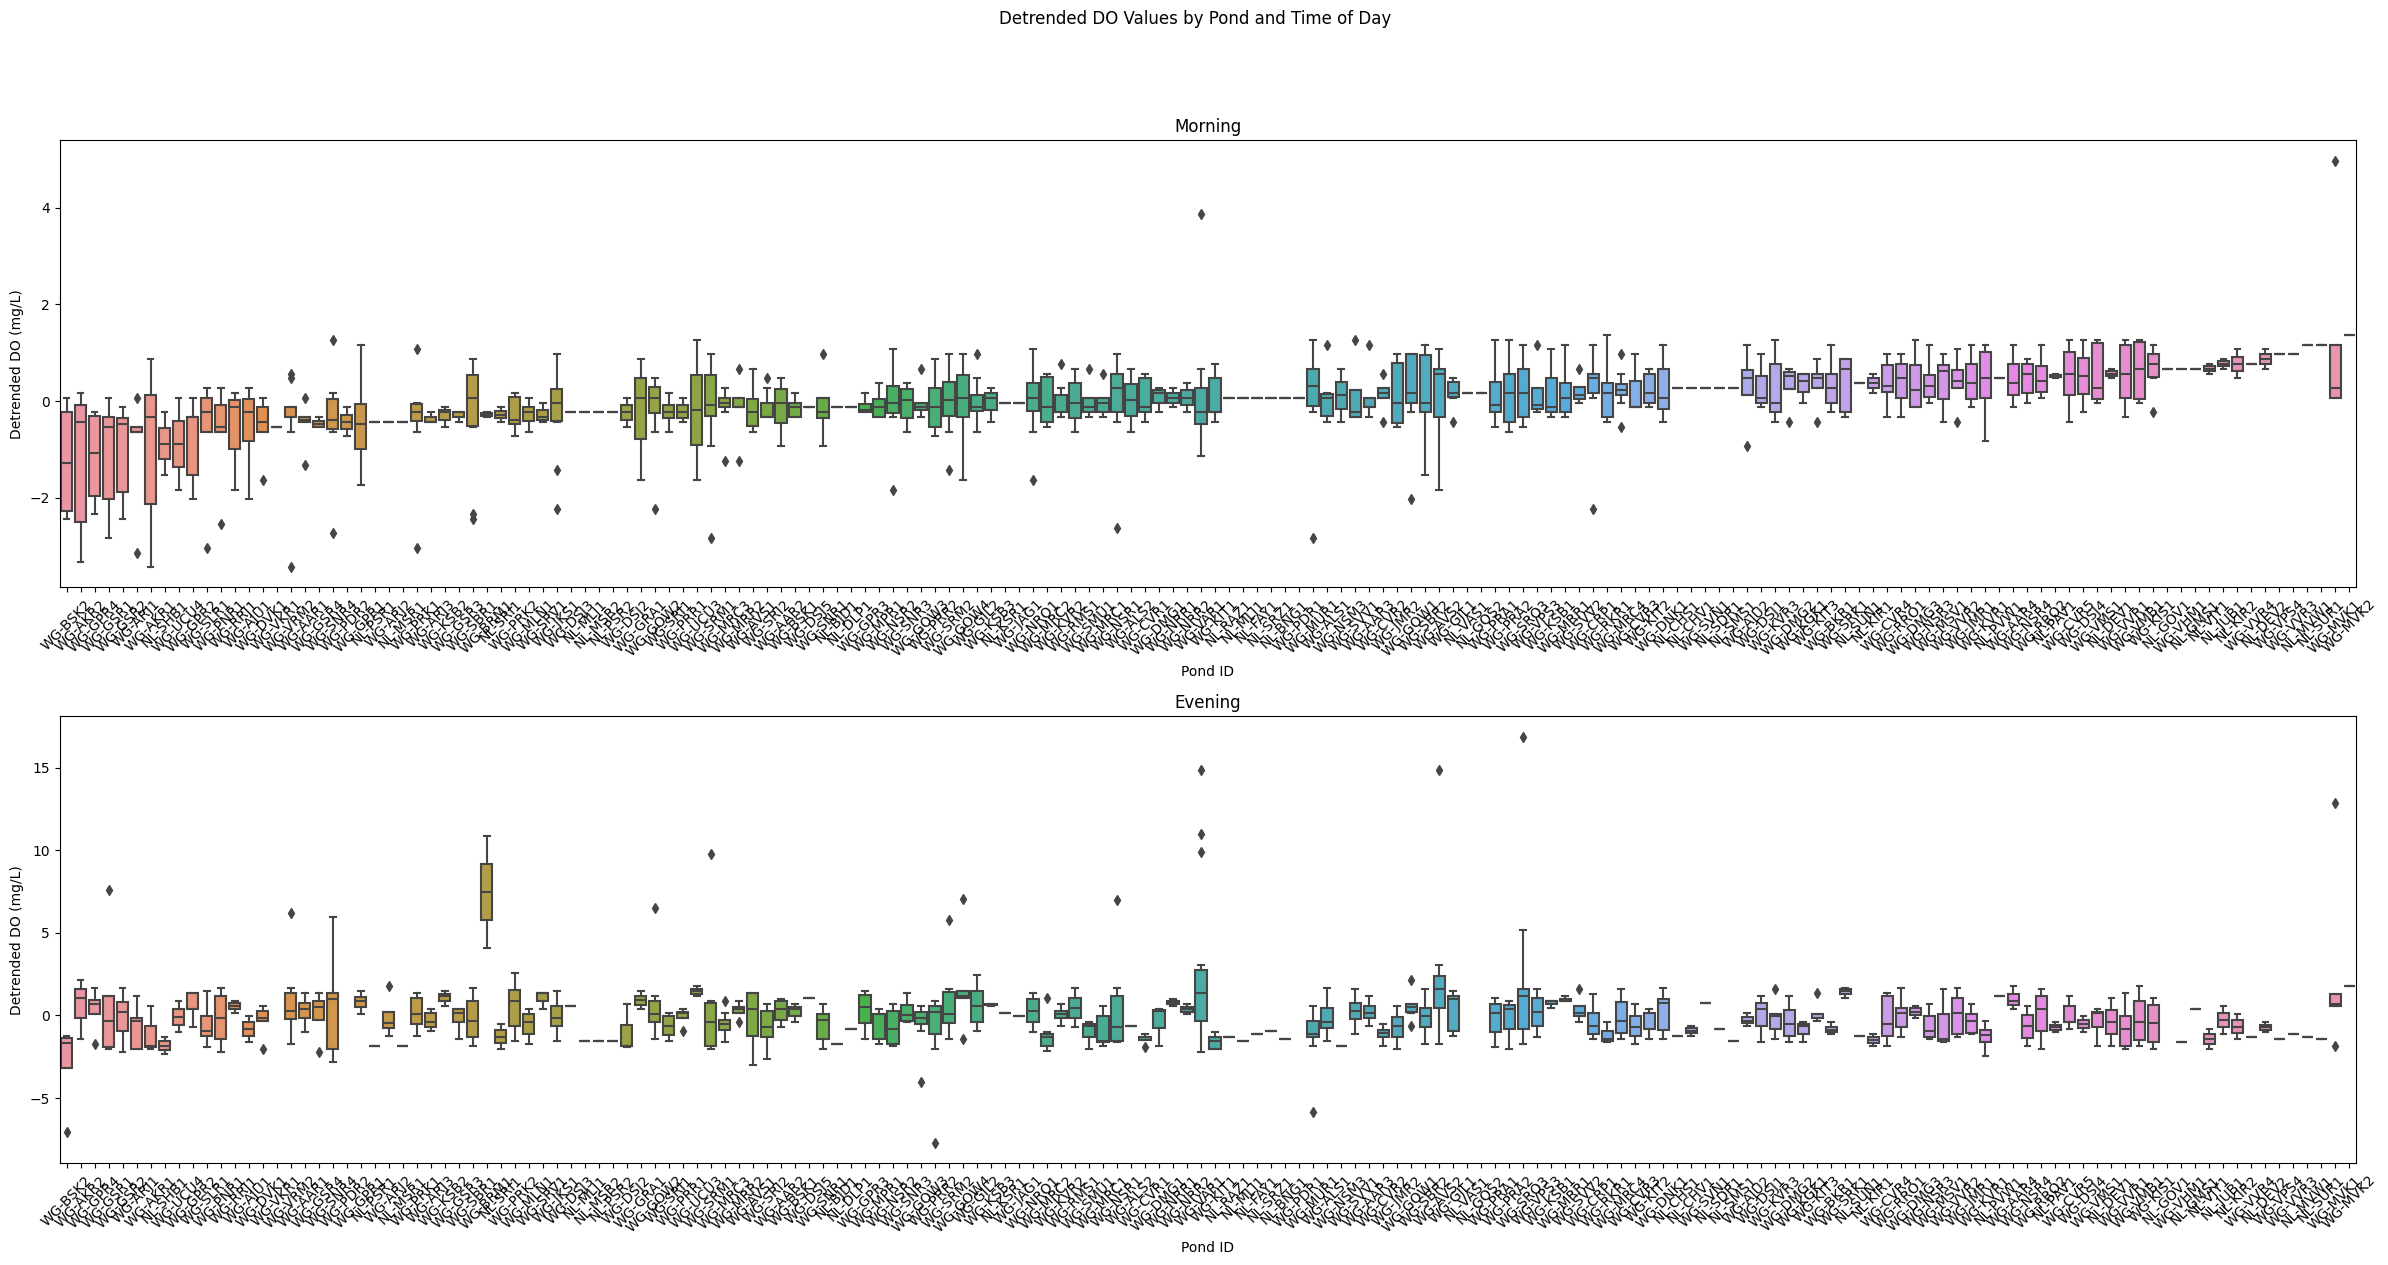

In [25]:
# Calculate morning means to sort ponds
morning_means = winkler_df[winkler_df['morning']].groupby('pond_id')['do_mg_per_L_detrended'].mean()
pond_order = morning_means.sort_values().index

# Create separate plots for morning and evening
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

# Morning plot
morning_data = winkler_df[winkler_df['morning']]
sns.boxplot(data=morning_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax1)
ax1.set_title('Morning')
ax1.set_xlabel('Pond ID')
ax1.set_ylabel('Detrended DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)

# Evening plot  
evening_data = winkler_df[~winkler_df['morning']]
sns.boxplot(data=evening_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax2)
ax2.set_title('Evening')
ax2.set_xlabel('Pond ID')
ax2.set_ylabel('Detrended DO (mg/L)')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Detrended DO Values by Pond and Time of Day', y=1.05)
plt.tight_layout()
plt.show()


WG ponds definitely have lower water quality

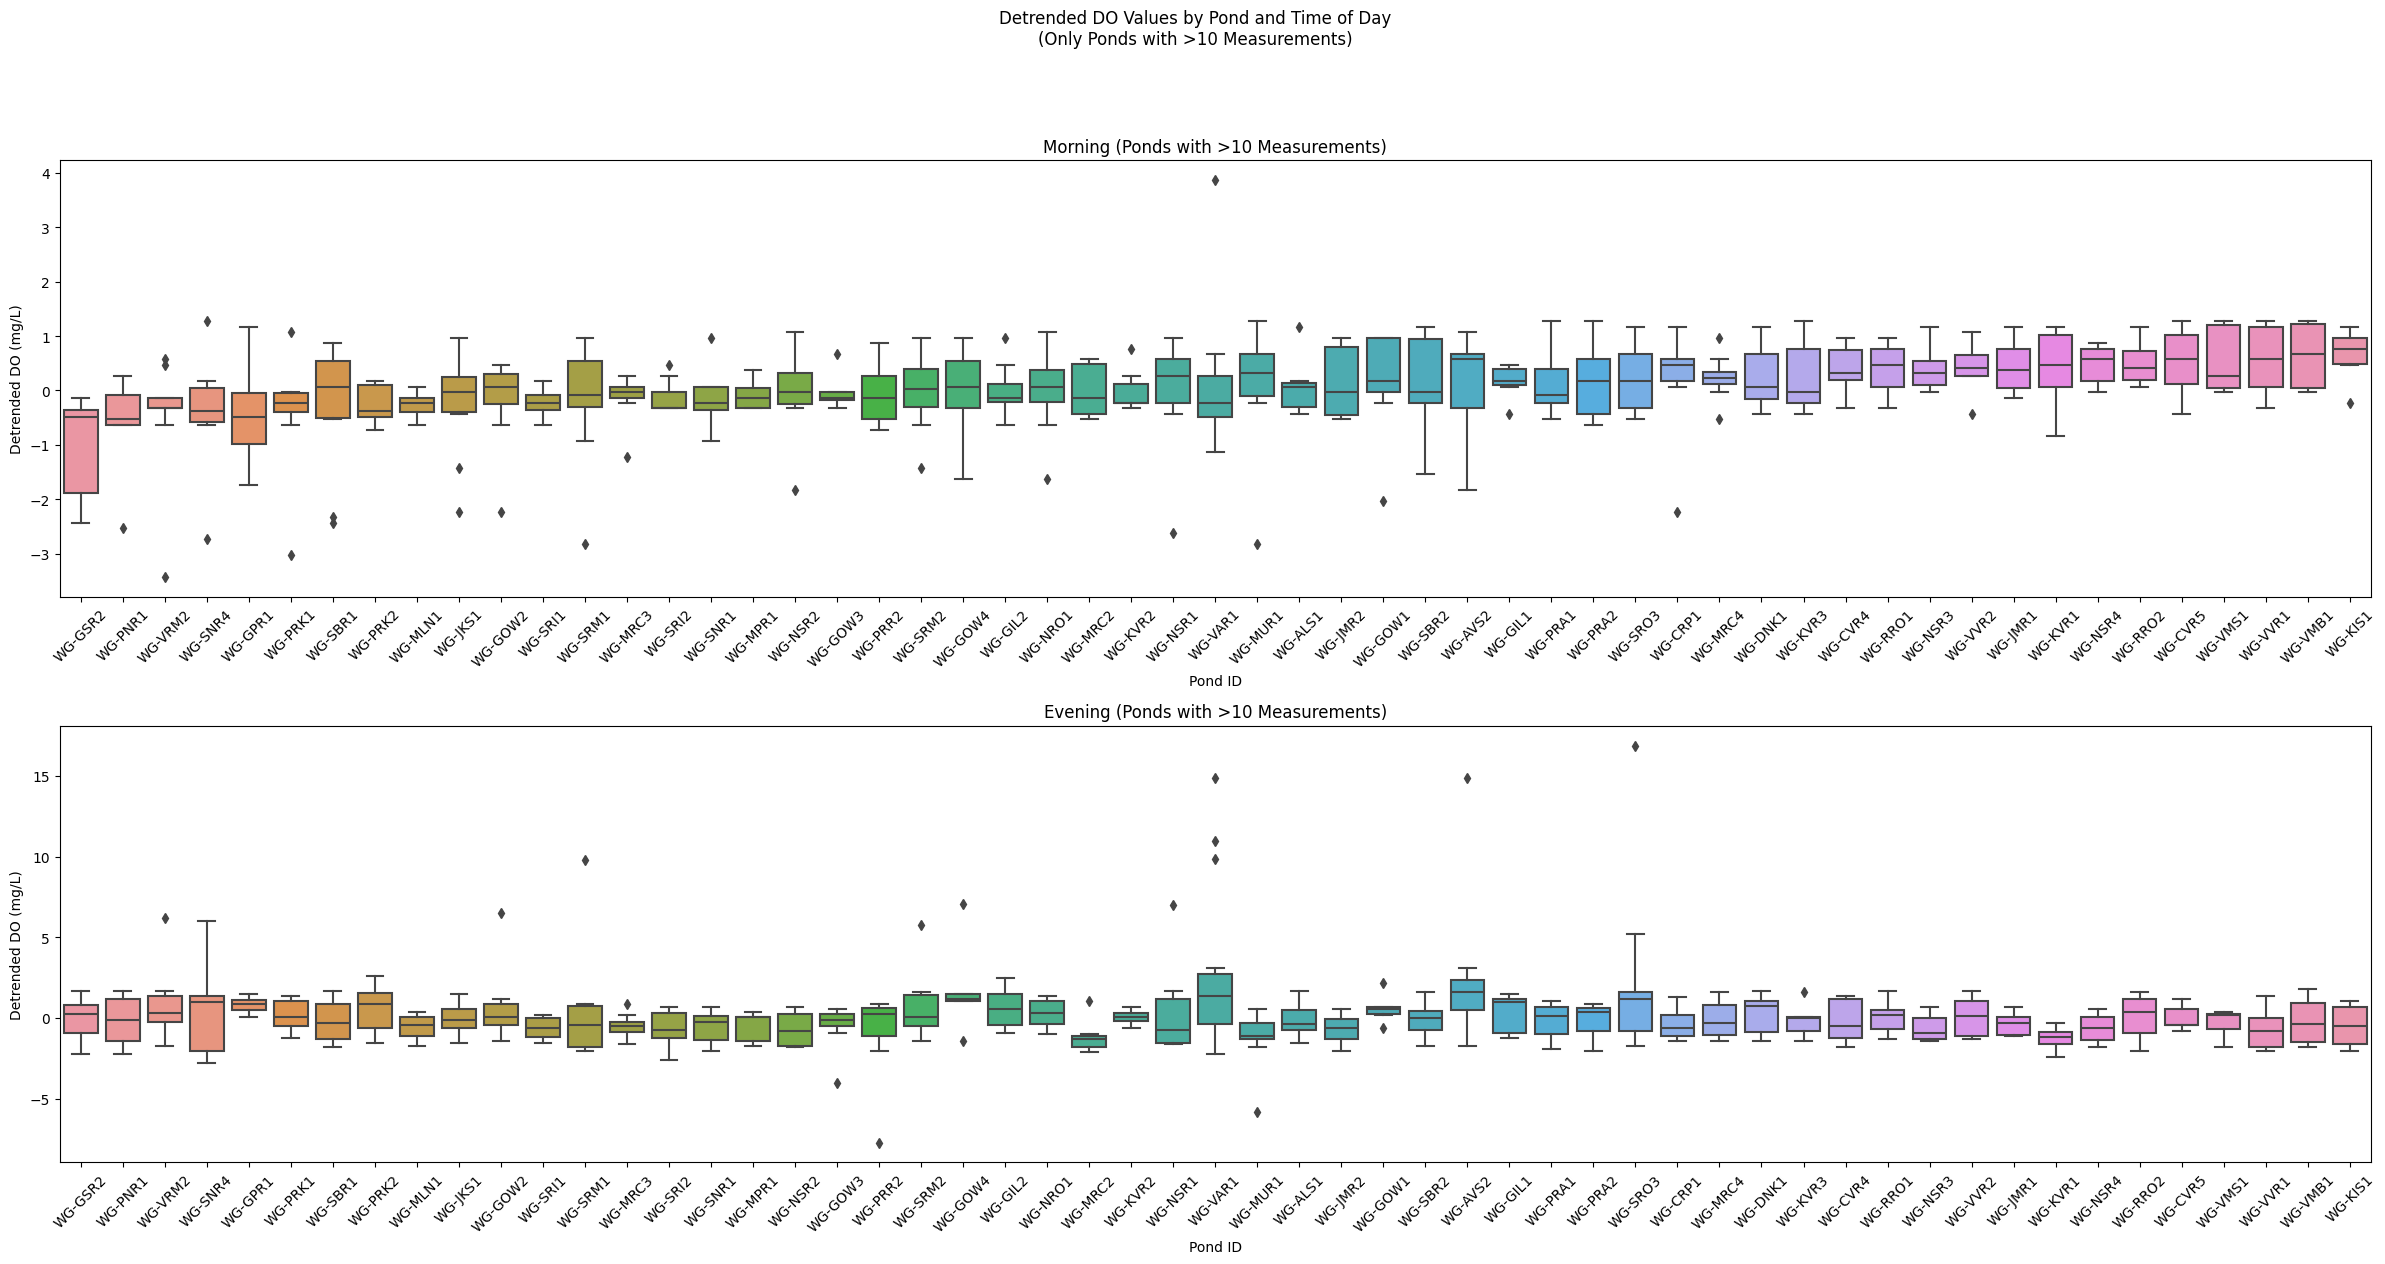

In [26]:
# Get ponds with more than 10 measurements
pond_counts = winkler_df.groupby('pond_id').size()
valid_ponds = pond_counts[pond_counts > 10].index

# Filter data for valid ponds
winkler_df_filtered = winkler_df[winkler_df['pond_id'].isin(valid_ponds)]

# Calculate morning means to sort ponds
morning_means = winkler_df_filtered[winkler_df_filtered['morning']].groupby('pond_id')['do_mg_per_L_detrended'].mean()
pond_order = morning_means.sort_values().index

# Create separate plots for morning and evening
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

# Morning plot
morning_data = winkler_df_filtered[winkler_df_filtered['morning']]
sns.boxplot(data=morning_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax1)
ax1.set_title('Morning (Ponds with >10 Measurements)')
ax1.set_xlabel('Pond ID')
ax1.set_ylabel('Detrended DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)

# Evening plot  
evening_data = winkler_df_filtered[~winkler_df_filtered['morning']]
sns.boxplot(data=evening_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax2)
ax2.set_title('Evening (Ponds with >10 Measurements)')
ax2.set_xlabel('Pond ID')
ax2.set_ylabel('Detrended DO (mg/L)')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Detrended DO Values by Pond and Time of Day\n(Only Ponds with >10 Measurements)', y=1.05)
plt.tight_layout()
plt.show()

Categoricals to deal with:
- farm
- region
- month
- pond_id
- village
- SCL

In [27]:
categoricals = ['farm', 'region', 'month', 'pond_id', 'village', 'SCL']
non_categoricals = winkler_df.columns[~winkler_df.columns.isin(categoricals)].tolist()

In [28]:
# Calculate correlations separately for morning and evening
morning_data = winkler_df[winkler_df['morning']]
evening_data = winkler_df[~winkler_df['morning']]

# Calculate correlations for morning data
morning_corr = morning_data[non_categoricals].corr()['do_mg_per_L_detrended'].abs()
morning_high_corr = morning_corr[morning_corr > 0.17].index.tolist()

# Calculate correlations for evening data  
evening_corr = evening_data[non_categoricals].corr()['do_mg_per_L_detrended'].abs()
evening_high_corr = evening_corr[evening_corr > 0.17].index.tolist()

# Combine features that are important for either morning or evening
high_corr_features = list(set(morning_high_corr + evening_high_corr))

# Remove target variables from features list
high_corr_features = [col for col in high_corr_features if col not in ['do_mg_per_L', 'do_mg_per_L_detrended']]

print("Number of high correlation features:", len(high_corr_features))


Number of high correlation features: 17


In [29]:
high_corr_features

['total_cloud_cover_entire_atmosphere_39',
 'prev_ammonia_mg_per_L',
 'downward_shortwave_radiation_flux_15',
 'temperature_2m_above_ground_sample',
 'has_sprinkler',
 'temperature_2m_above_ground_39',
 'relative_humidity_2m_above_ground_39',
 'downward_shortwave_radiation_flux_39',
 'prev_do_mg_per_L_detrended',
 'fertilizer_manure',
 'downward_shortwave_radiation_flux_sample',
 'downward_shortwave_radiation_flux_33',
 'prev_do_mg_per_L',
 'downward_shortwave_radiation_flux_same_day_sum',
 'total_cloud_cover_entire_atmosphere_15',
 'prev_feed_amount_kg',
 'prev_turbidity_cm']

In [30]:
winkler_df.columns.tolist()

['pond_id',
 'region',
 'farm',
 'morning',
 'hour',
 'do_mg_per_L',
 'do_winkler',
 'prev_matches_time',
 'prev_do_mg_per_L',
 'prev_ph',
 'prev_turbidity_cm',
 'prev_ammonia_mg_per_L',
 'prev_individuals_air_gulping',
 'prev_individuals_tail_splashing',
 'prev_dead_fish',
 'prev_feed_amount_kg',
 'prev_stocking_density_per_acre',
 'prev_weight',
 'prev_species_catla',
 'prev_species_rohu',
 'prev_species_roopchand',
 'prev_species_grass_carp',
 'prev_species_pangasius',
 'prev_species_whiteleg_shrimp',
 'property_area_acres',
 'pond_area_acres',
 'pond_depth_meters',
 'has_water_pump',
 'has_aerator',
 'has_motor_boat',
 'has_sprinkler',
 'pond_preparation',
 'village',
 'fertilizer_manure',
 'fertilizer_dap',
 'fertilizer_potash',
 'fertilizer_urea',
 'fertilizer_phosphate',
 'fertilizer_amm_sulph',
 'fertilizer_probiotics',
 'fertilizer_magnesium',
 'fertilizer_gromor',
 'fertilizer_lime',
 'fertilizer_none',
 'feed_mash',
 'feed_pellets_float',
 'feed_pellets_sink',
 'feed_dorb',


In [31]:
experiment_df = winkler_df.drop(columns=['do_mg_per_L_detrended', 'prev_do_mg_per_L_detrended']).copy()

In [32]:
# Feature categories
base_weather_forecast_features = experiment_df.columns[experiment_df.columns.str.contains('downward_shortwave|precipitable|relative_hum|specific_hum|temperature_2m|total_cloud|total_precip')].tolist()
ext_weather_forecast_features = base_weather_forecast_features + experiment_df.columns[experiment_df.columns.str.contains('u_component|v_component')].tolist()
satellite_features = ['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'MSK_CLDPRB', 'SCL', 'WVP', 'hours_from_measurement', 'ndvi','ndwi']
lag_features = experiment_df.columns[experiment_df.columns.str.startswith('prev_')].tolist()
pond_features = (
  experiment_df.columns[experiment_df.columns.str.startswith('fertilizer_|feed_|has_')].tolist() + ['pond_area_acres', 'property_area_acres', 'pond_depth_meters', 'pond_preparation']
)

# Feature sets
base_feature_set = ['morning', 'region', 'hour'] + base_weather_forecast_features
ext_weather_forecast_set = base_feature_set + ext_weather_forecast_features

# Add categoricals
base_w_categoricals = list(set(base_feature_set + categoricals))
base_w_lag_features = base_feature_set + lag_features
base_w_satellite_features = base_feature_set + satellite_features
base_w_pond_features = base_feature_set + pond_features
high_corr_set = high_corr_features + ['morning', 'region']

In [33]:
# Import necessary libraries
from typing import List, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, TargetEncoder, LabelEncoder

from fwi_predict.wq import get_in_required_range

class DiurnalDetrend(BaseEstimator, TransformerMixin):
    """Detrend data by subtracting morning/evening means."""
    def fit(self, X, y=None):
        # Calculate means for morning/evening
        df = pd.DataFrame({'y': y, 'morning': X['morning']})
        self.morning_mean_ = df[df['morning']]['y'].mean()
        self.evening_mean_ = df[~df['morning']]['y'].mean()
        return self

    def transform(self, X, y=None):
        if y is not None:
            y_detrended = y.copy()
            y_detrended[X['morning']] -= self.morning_mean_
            y_detrended[~X['morning']] -= self.evening_mean_
            return y_detrended
        return X
    
    def inverse_transform(self, X, y):
        y_retrended = y.copy()
        y_retrended[X['morning']] += self.morning_mean_
        y_retrended[~X['morning']] += self.evening_mean_
        return y_retrended


def evaluate_predictions(y_true, y_pred, morning_series):
    """Evaluate model performance including DO range classification."""
    # Get range classifications
    time_of_day = morning_series.apply(lambda x: 'morning' if x else 'evening')
    true_ranges = get_in_required_range('do_mg_per_L', y_true, time_of_day)
    pred_ranges = get_in_required_range('do_mg_per_L', y_pred, time_of_day)
    
    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    range_accuracy = (true_ranges == pred_ranges).mean()
    
    return {
        'r2_score': r2,
        'range_accuracy': range_accuracy,
        'y_true': y_true,
        'y_pred': y_pred,
        'true_ranges': true_ranges,
        'pred_ranges': pred_ranges
    }


def run_experiment(df: pd.DataFrame, 
                  feature_set: List[str],
                  categoricals: List[str],
                  do_feature_selection: bool = False) -> Dict:
    """Run modeling experiment with given feature set."""
    
    # Prepare data
    X = df[feature_set]
    y = df['do_mg_per_L']
    
    # Create preprocessing steps
    numeric_features = [col for col in feature_set if col not in categoricals]
    categorical_features = [col for col in feature_set if col in categoricals]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', TargetEncoder(), categorical_features)
        ]
    )
    
    # Create pipeline
    steps = [
        ('detrend', DiurnalDetrend()),
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
    ]
    
    if do_feature_selection:
        steps.append(('feature_selection', 
                     RFECV(RandomForestRegressor(random_state=42), cv=5, scoring='r2', criterion='squared_error'))) # Consider scoring on
    
    steps.append(('regressor', RandomForestRegressor(random_state=42)))
    
    pipeline = Pipeline(steps)
    
    # Define parameter grid
    param_grid = {
        'regressor__n_estimators': [100, 150, 250],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [5, 10],
        'regressor__min_samples_leaf': [5, 8, 10]
    }
    
    # Perform grid search
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit model
    grid_search.fit(X, y)
    
    # Get cross-validation predictions
    cv_predictions = cross_val_predict(
        grid_search.best_estimator_,
        X, y,
        cv=cv
    )
    
    # Evaluate performance
    results = evaluate_predictions(y, cv_predictions, df['morning'])
    
    # Plot hyperparameter effects
    cv_results = pd.DataFrame(grid_search.cv_results_)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    sns.boxplot(data=cv_results, x='param_regressor__n_estimators', y='mean_test_score', ax=ax1)
    ax1.set_title('Effect of n_estimators')
    ax1.set_ylabel('Mean CV Score (R²)')
    
    sns.boxplot(data=cv_results, x='param_regressor__max_depth', y='mean_test_score', ax=ax2)
    ax2.set_title('Effect of max_depth')
    ax2.set_ylabel('Mean CV Score (R²)')
    
    sns.boxplot(data=cv_results, x='param_regressor__min_samples_split', y='mean_test_score', ax=ax3)
    ax3.set_title('Effect of min_samples_split')
    ax3.set_ylabel('Mean CV Score (R²)')
    
    sns.boxplot(data=cv_results, x='param_regressor__min_samples_leaf', y='mean_test_score', ax=ax4)
    ax4.set_title('Effect of min_samples_leaf')
    ax4.set_ylabel('Mean CV Score (R²)')
    
    plt.tight_layout()
    plt.show()
    
    # Plot predictions vs actuals
    plt.figure(figsize=(15, 5))
    
    # Morning predictions
    plt.subplot(1, 2, 1)
    morning_mask = df['morning']
    plt.scatter(results['y_true'][morning_mask], 
                results['y_pred'][morning_mask], alpha=0.5)
    plt.plot([results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()],
             [results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()], 
             'r--', lw=2, label='Perfect prediction')
    
    # Add trend line
    z = np.polyfit(results['y_true'][morning_mask], results['y_pred'][morning_mask], 1)
    p = np.poly1d(z)
    plt.plot([results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()],
             [p(results['y_true'][morning_mask].min()), 
              p(results['y_true'][morning_mask].max())],
             'g--', lw=2, label='Trend line')
    plt.legend()
    plt.xlabel('Actual DO (mg/L)')
    plt.ylabel('Predicted DO (mg/L)')
    plt.title('Morning: Predicted vs actual DO levels')
    
    # Evening predictions
    plt.subplot(1, 2, 2)
    evening_mask = ~df['morning']
    plt.scatter(results['y_true'][evening_mask],
                results['y_pred'][evening_mask], alpha=0.5)
    plt.plot([results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             [results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             'r--', lw=2, label='Perfect prediction')
    
    # Add trend line
    z = np.polyfit(results['y_true'][evening_mask], results['y_pred'][evening_mask], 1)
    p = np.poly1d(z)
    plt.plot([results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             [p(results['y_true'][evening_mask].min()),
              p(results['y_true'][evening_mask].max())],
             'g--', lw=2, label='Trend line')
    plt.legend()
    plt.xlabel('Actual DO (mg/L)')
    plt.ylabel('Predicted DO (mg/L)')
    plt.title('Evening: Predicted vs actual DO levels')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_estimator': grid_search.best_estimator_,
        'results': results
    }


Running experiment with base features...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


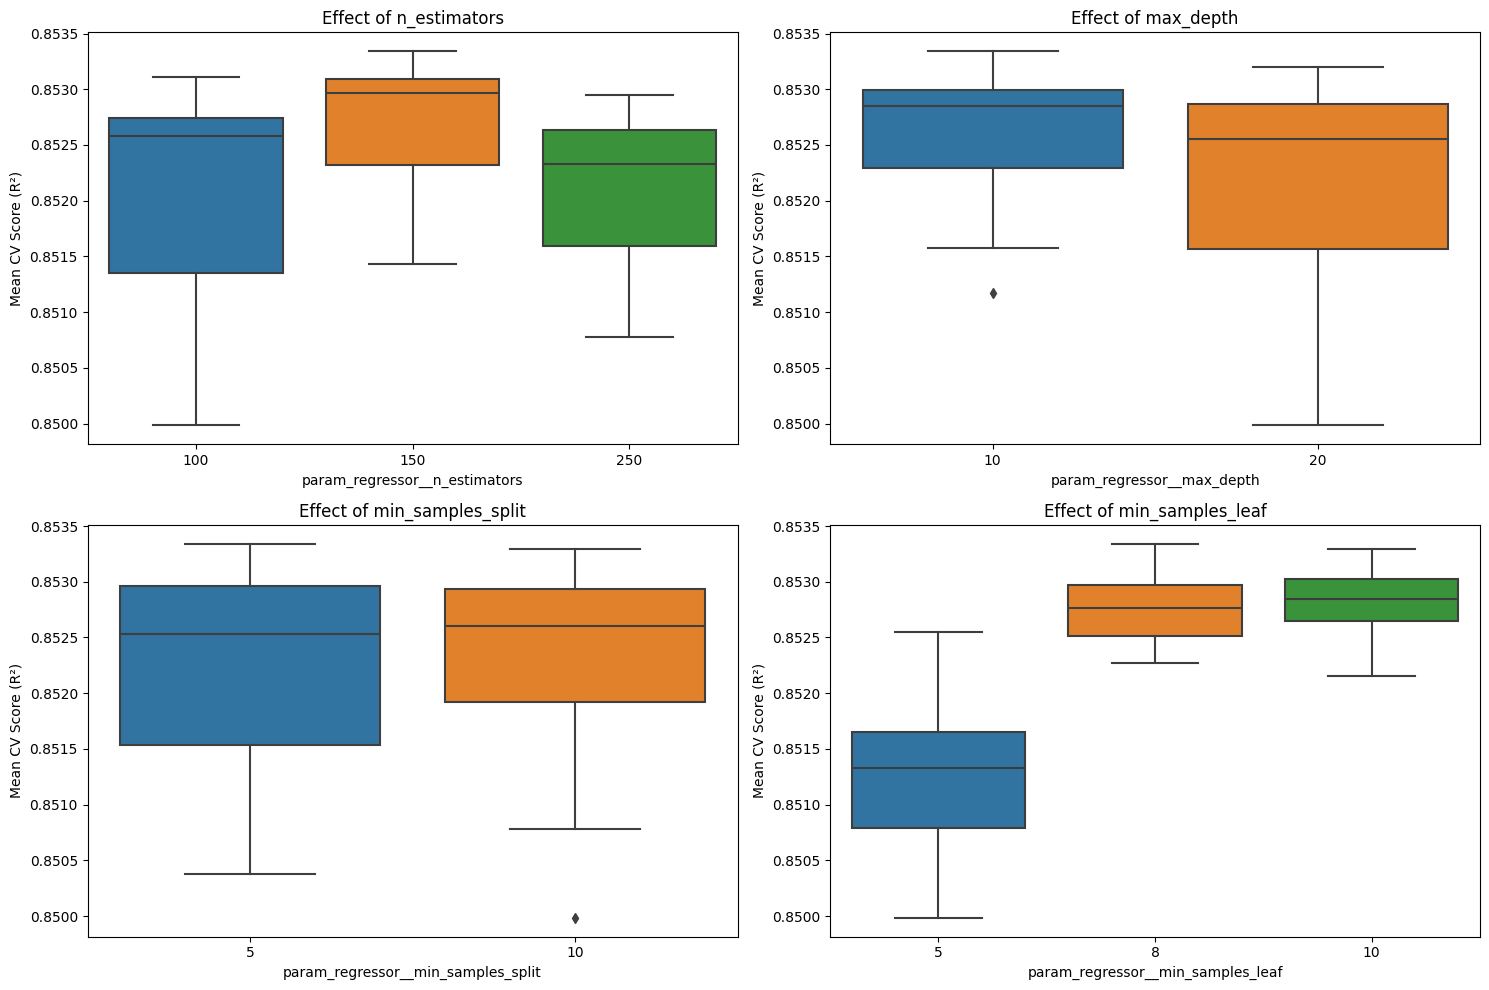

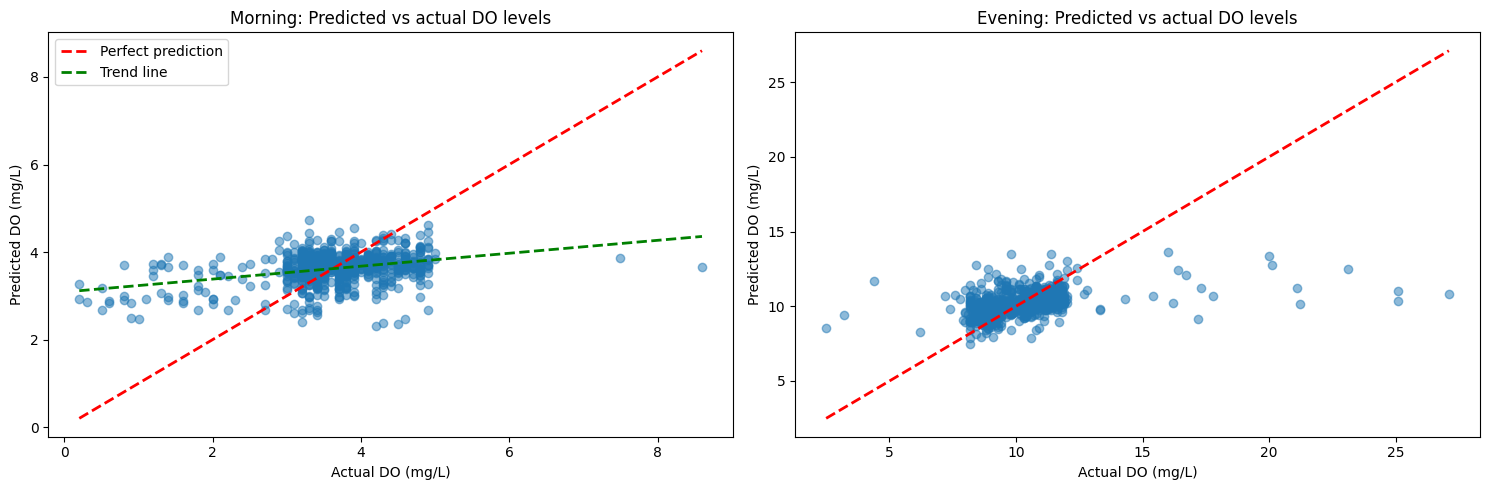

Best score: 0.853
Range prediction accuracy: 0.925

Running experiment with base_w_categoricals features...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


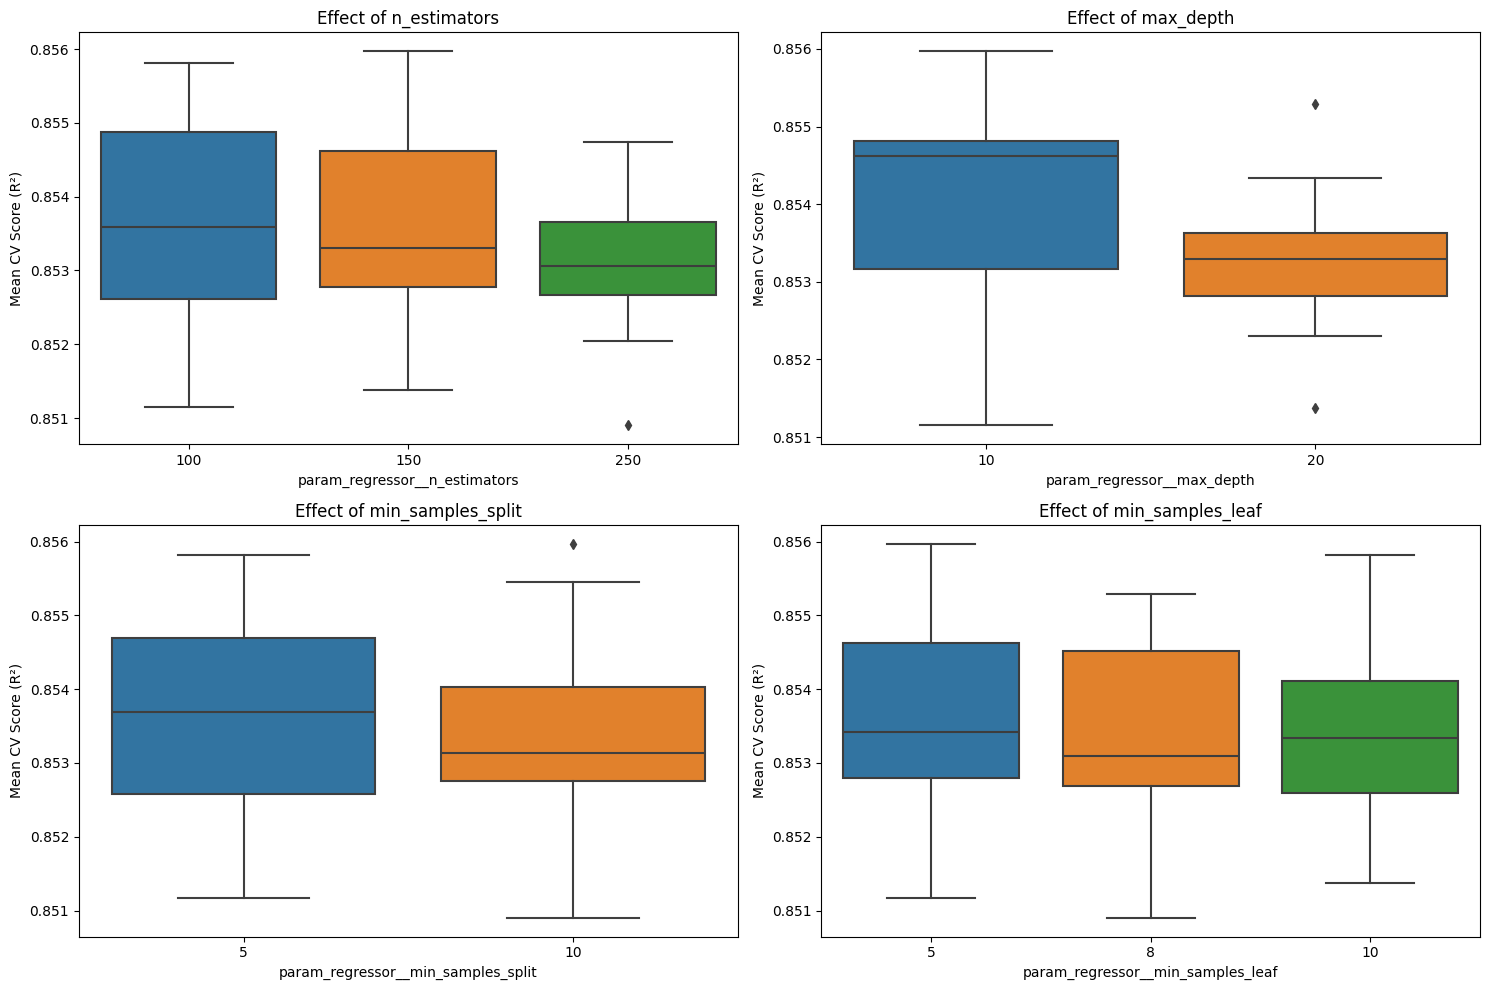

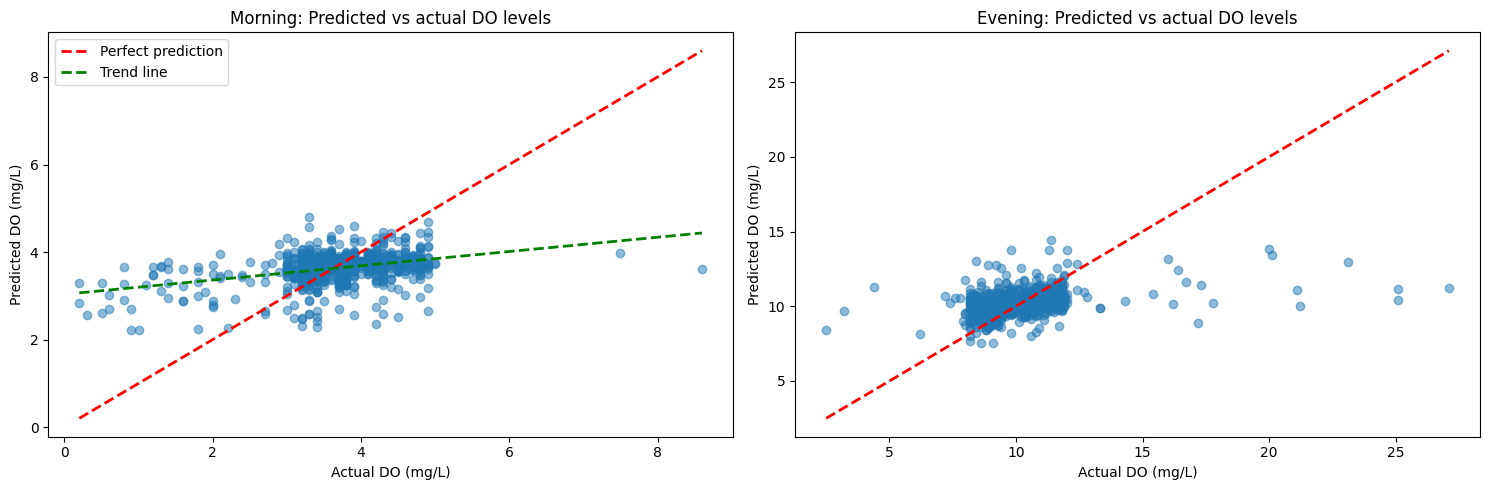

Best score: 0.856
Range prediction accuracy: 0.924

Running experiment with base_lag features...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


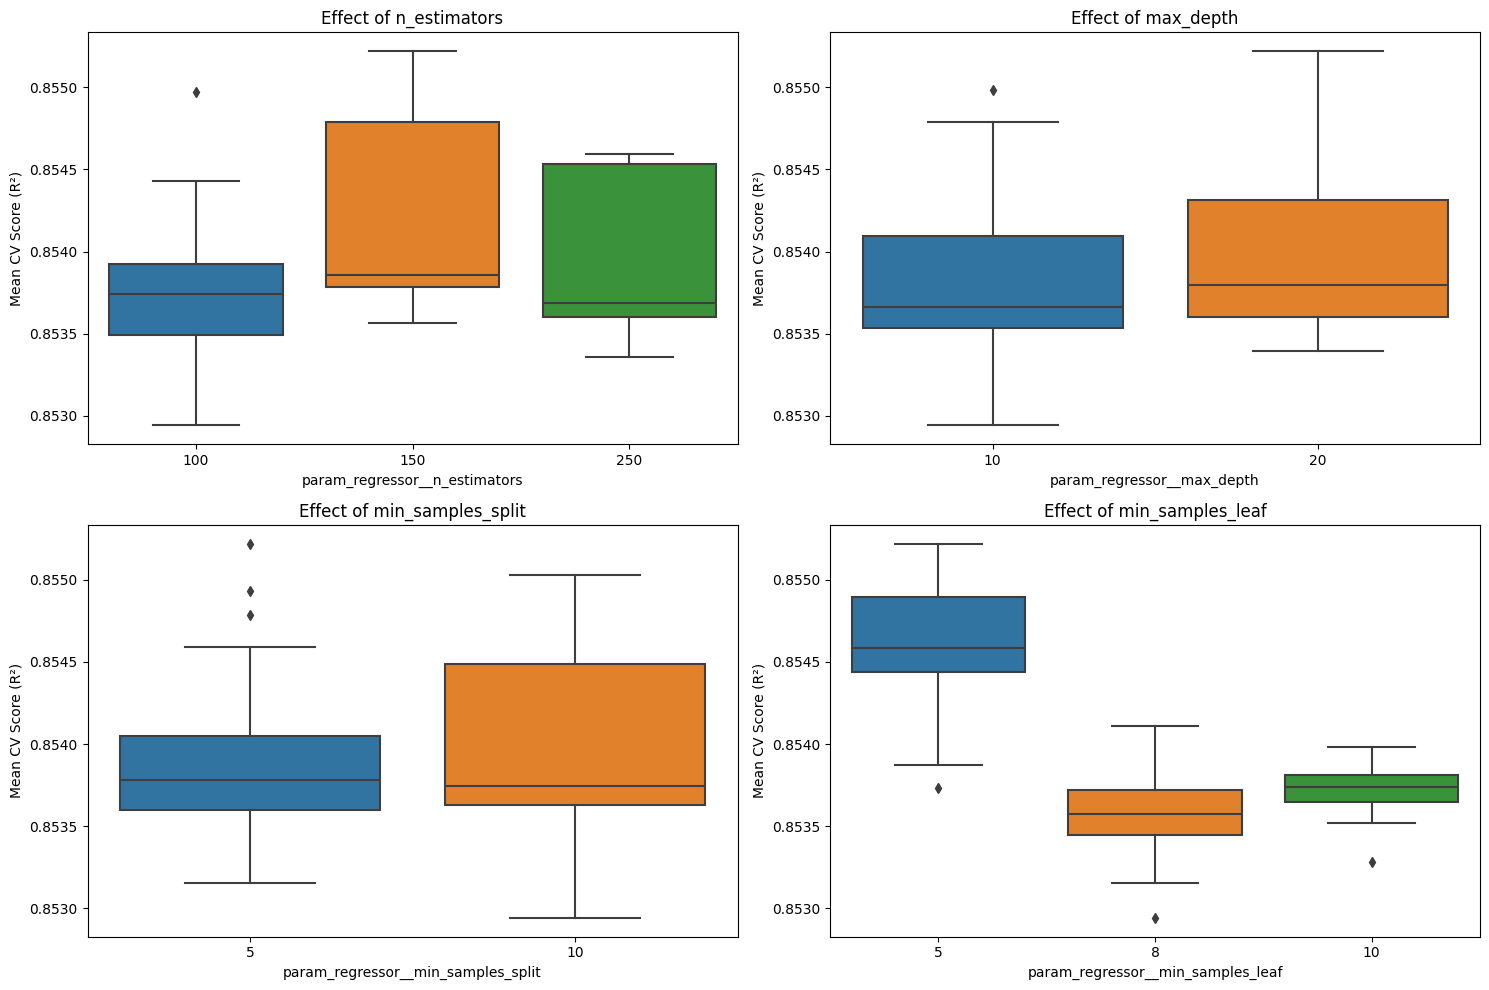

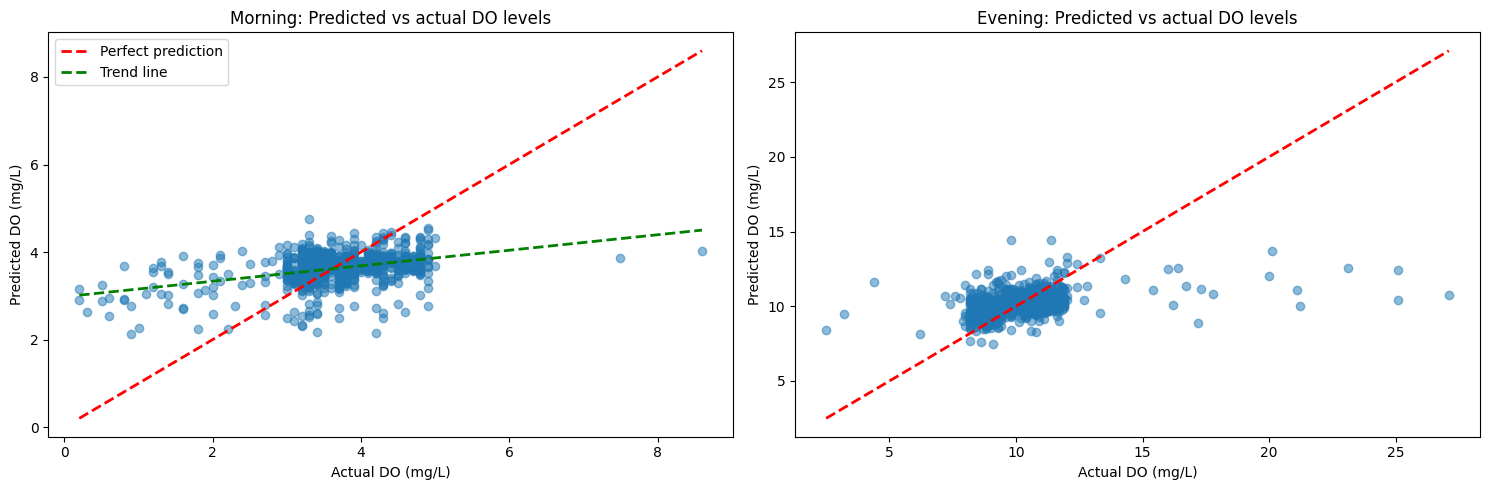

Best score: 0.855
Range prediction accuracy: 0.922

Running experiment with base_satellite features...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


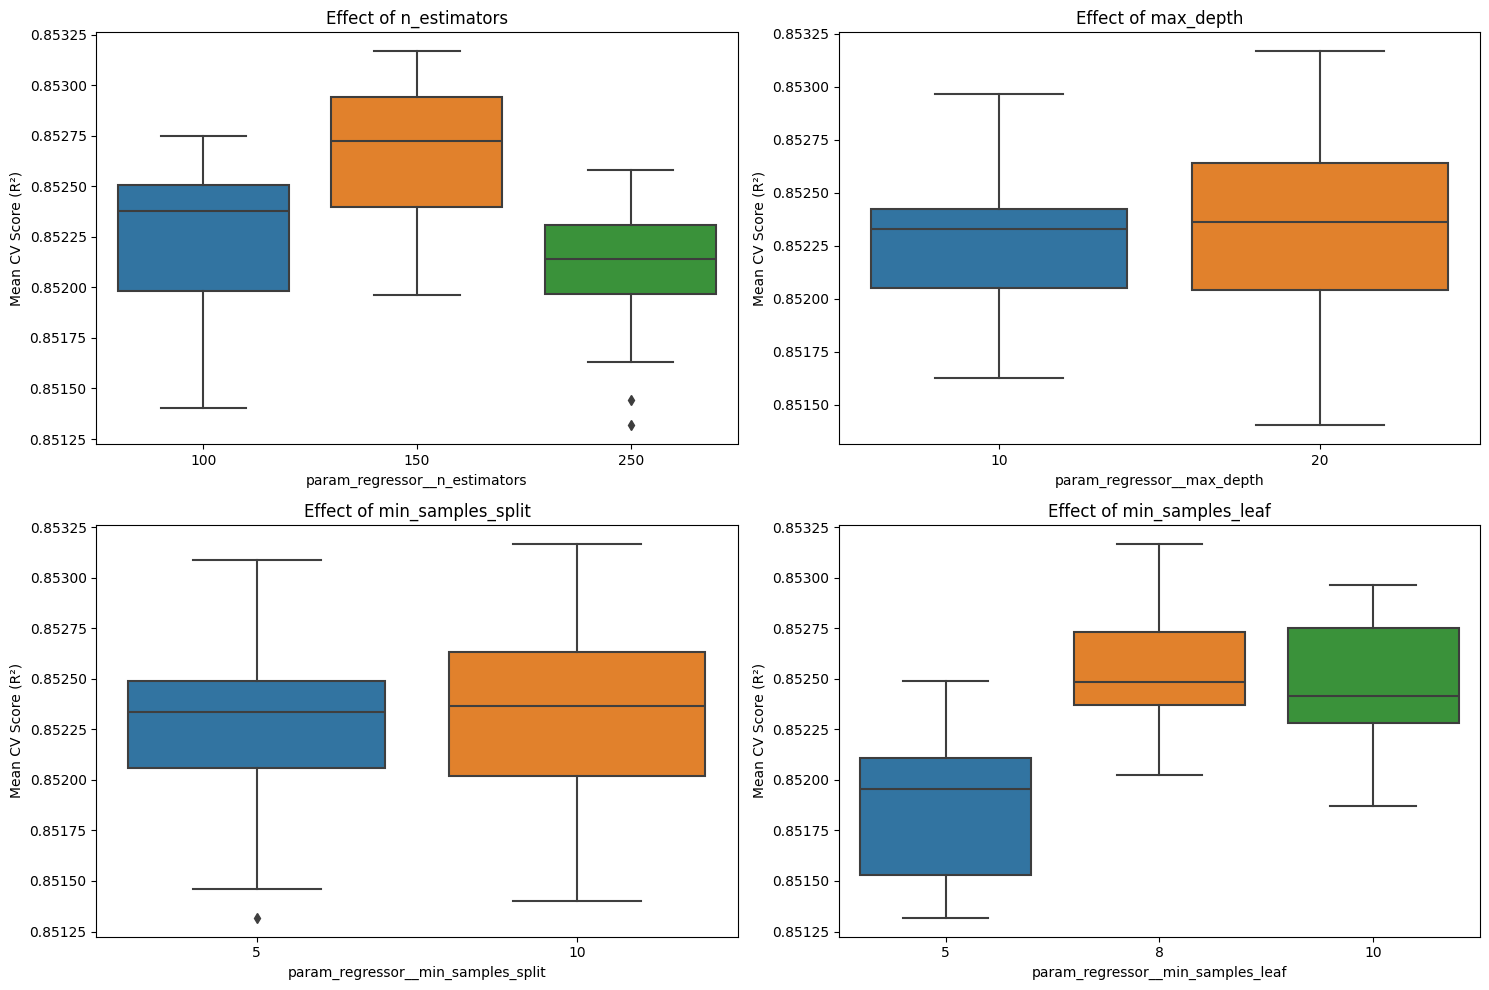

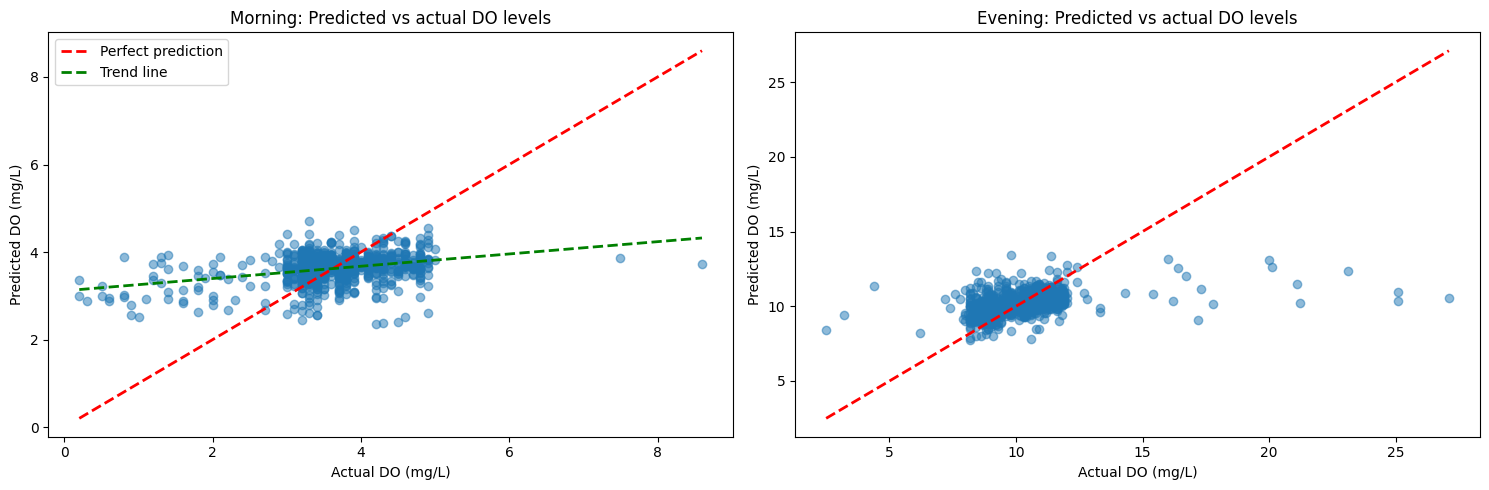

Best score: 0.853
Range prediction accuracy: 0.927

Running experiment with base_pond features...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


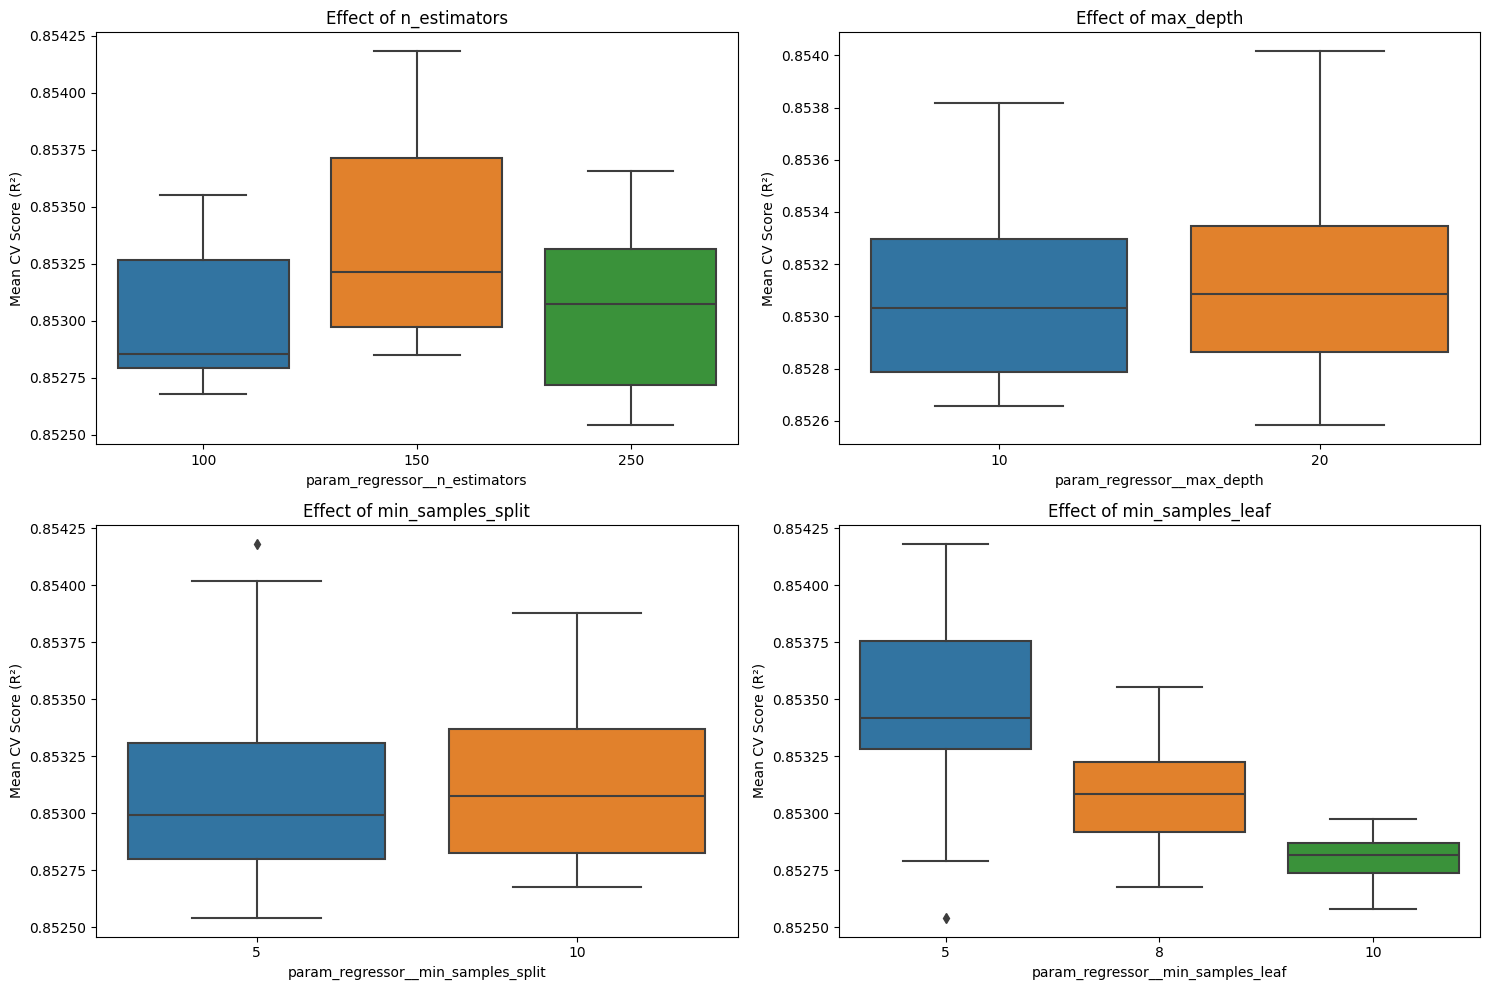

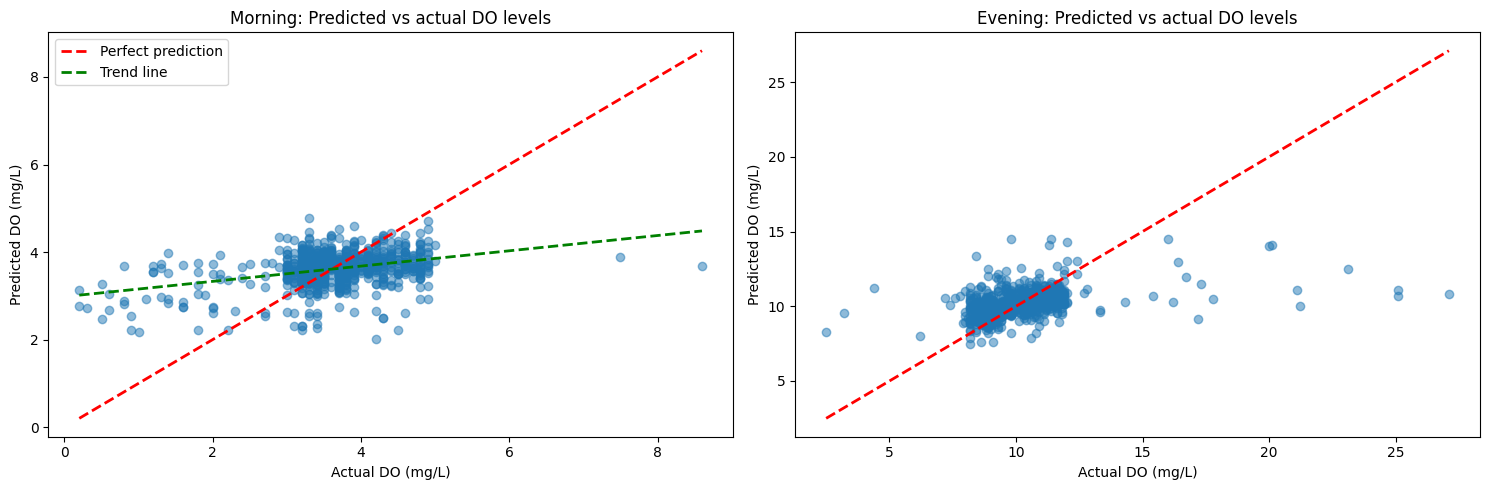

Best score: 0.854
Range prediction accuracy: 0.927

Running experiment with high_corr_set features...


KeyError: "['prev_do_mg_per_L_detrended'] not in index"

In [34]:
# Run experiments with different feature sets
feature_sets = {
    'base': base_feature_set,
    'base_w_categoricals': base_w_categoricals,
    'base_lag': base_w_lag_features,
    'base_satellite': base_w_satellite_features,
    'base_pond': base_w_pond_features,
    'high_corr_set': high_corr_set
}

results = {}
for name, features in feature_sets.items():
    print(f"\nRunning experiment with {name} features...")
    results[name] = run_experiment(experiment_df, features, categoricals)
    print(f"Best score: {results[name]['best_score']:.3f}")
    print(f"Range prediction accuracy: {results[name]['results']['range_accuracy']:.3f}")



Analyzing base feature set...

Metrics for below range DO:
Number of samples: 67
MSE: 5.112
R²: -0.593
Precision: 0.407
Recall: 0.328
Classification accuracy: 32.8%

Metrics for within range DO:
Number of samples: 1325
MSE: 0.715
R²: 0.931
Precision: 0.953
Recall: 0.968
Classification accuracy: 96.8%

Metrics for above range DO:
Number of samples: 25
MSE: 57.938
R²: -1.403
Precision: 0.389
Recall: 0.280
Classification accuracy: 28.0%


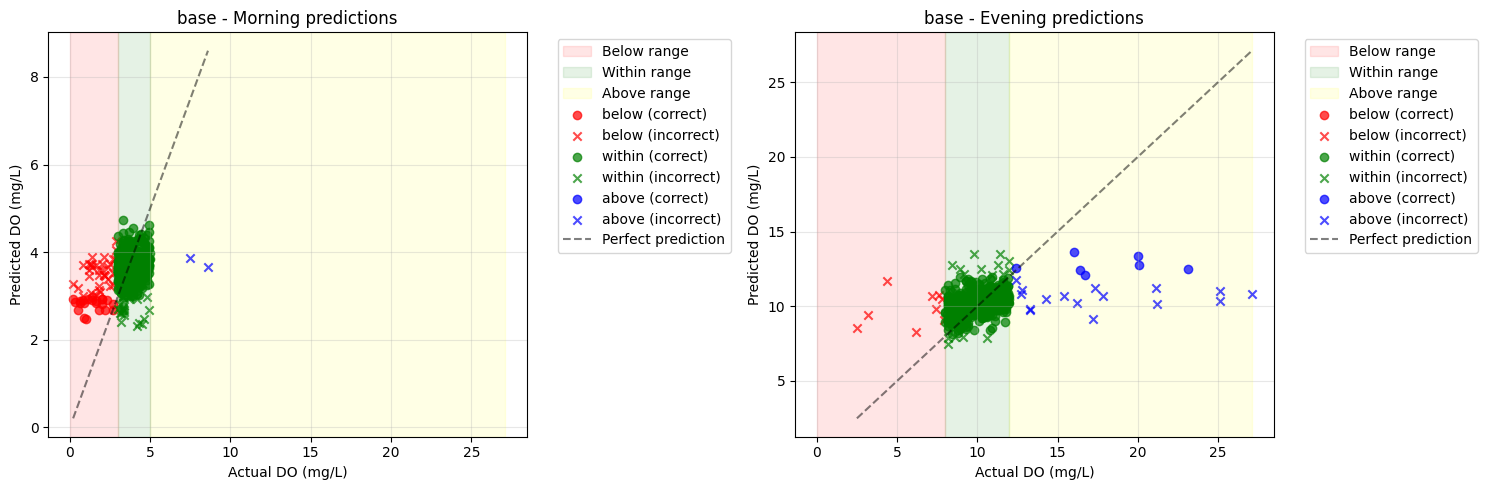


Analyzing base_w_categoricals feature set...

Metrics for below range DO:
Number of samples: 67
MSE: 5.007
R²: -0.560
Precision: 0.426
Recall: 0.299
Classification accuracy: 29.9%

Metrics for within range DO:
Number of samples: 1325
MSE: 0.741
R²: 0.929
Precision: 0.951
Recall: 0.968
Classification accuracy: 96.8%

Metrics for above range DO:
Number of samples: 25
MSE: 57.064
R²: -1.367
Precision: 0.286
Recall: 0.240
Classification accuracy: 24.0%


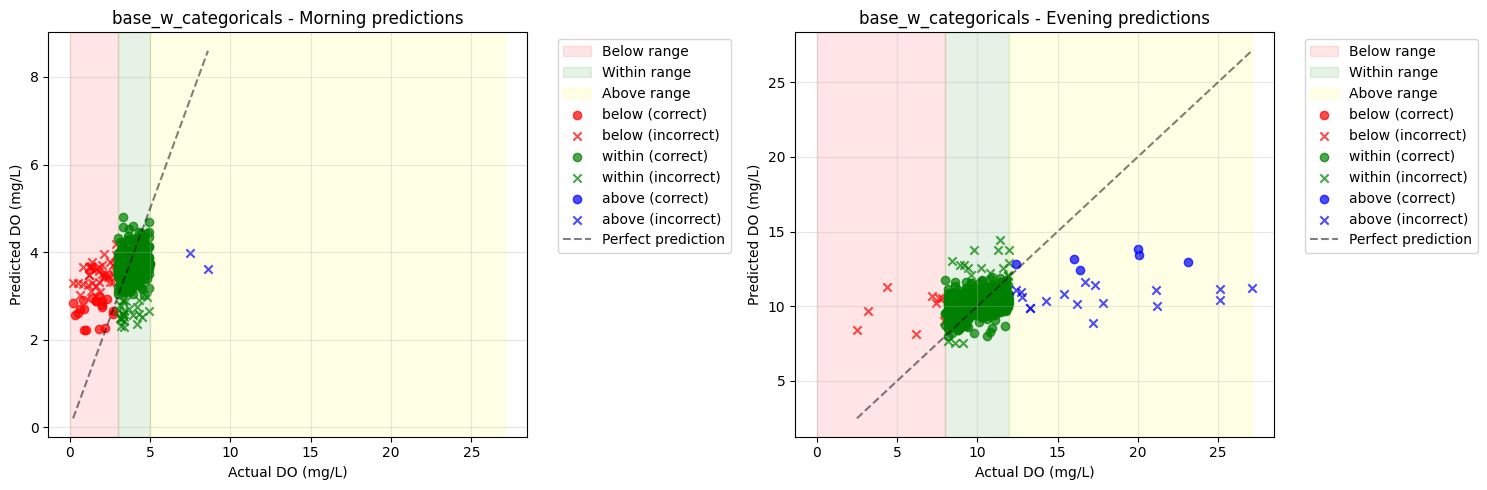


Analyzing base_lag feature set...

Metrics for below range DO:
Number of samples: 67
MSE: 5.024
R²: -0.565
Precision: 0.404
Recall: 0.284
Classification accuracy: 28.4%

Metrics for within range DO:
Number of samples: 1325
MSE: 0.715
R²: 0.931
Precision: 0.951
Recall: 0.967
Classification accuracy: 96.7%

Metrics for above range DO:
Number of samples: 25
MSE: 56.514
R²: -1.344
Precision: 0.304
Recall: 0.280
Classification accuracy: 28.0%


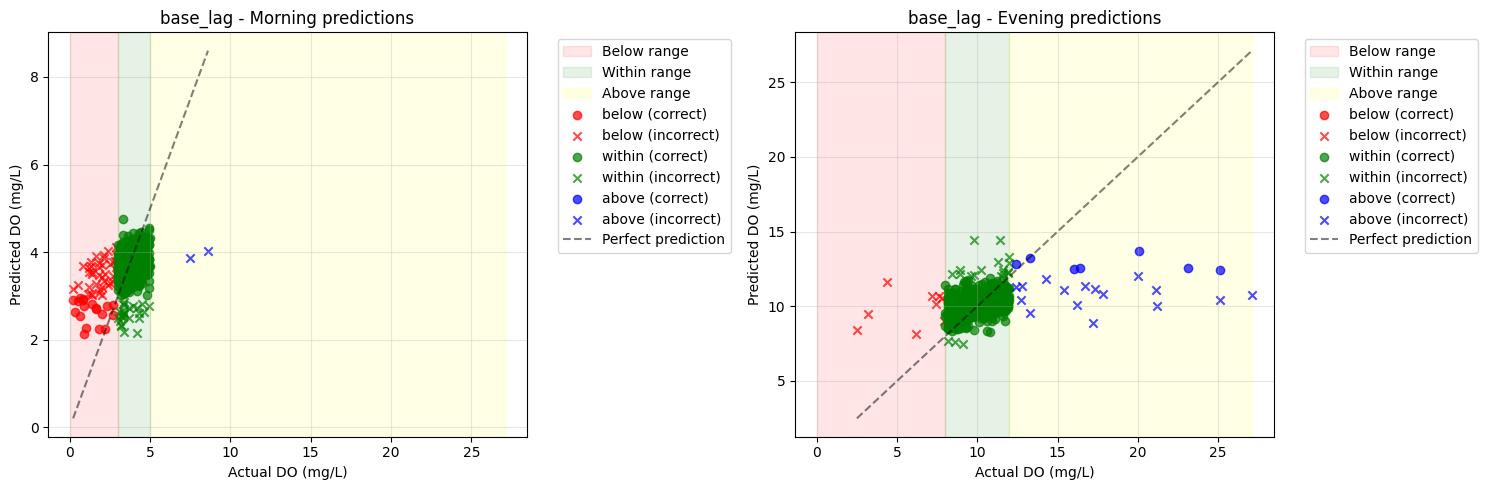


Analyzing base_satellite feature set...

Metrics for below range DO:
Number of samples: 67
MSE: 5.099
R²: -0.589
Precision: 0.412
Recall: 0.313
Classification accuracy: 31.3%

Metrics for within range DO:
Number of samples: 1325
MSE: 0.708
R²: 0.932
Precision: 0.953
Recall: 0.970
Classification accuracy: 97.0%

Metrics for above range DO:
Number of samples: 25
MSE: 58.717
R²: -1.436
Precision: 0.412
Recall: 0.280
Classification accuracy: 28.0%


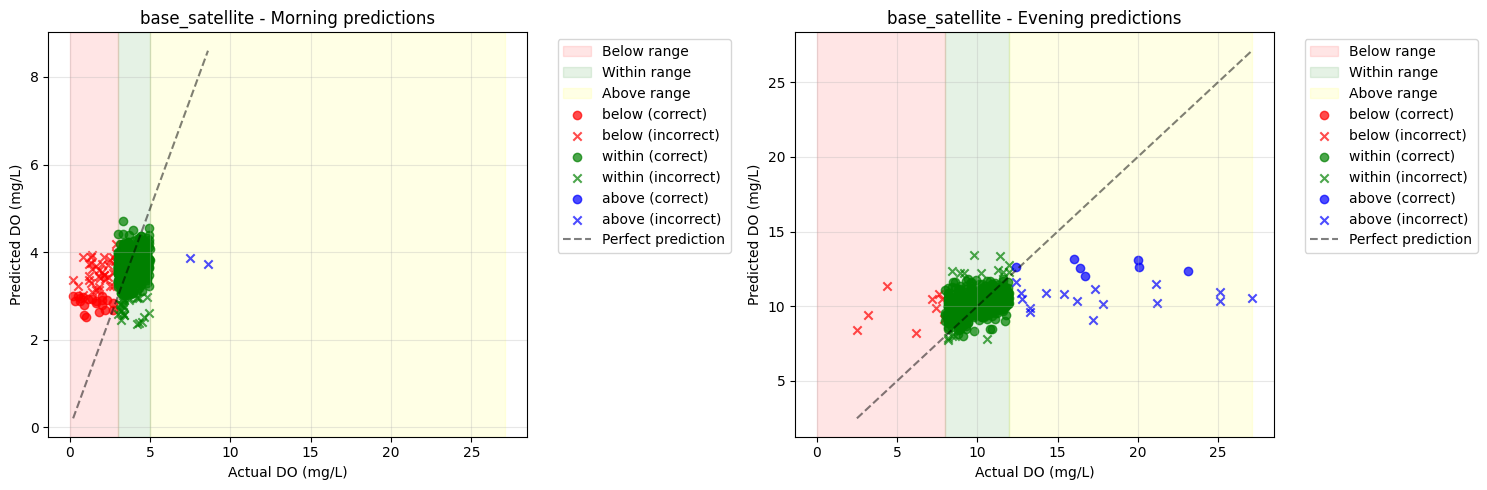


Analyzing base_pond feature set...

Metrics for below range DO:
Number of samples: 67
MSE: 4.809
R²: -0.498
Precision: 0.472
Recall: 0.373
Classification accuracy: 37.3%

Metrics for within range DO:
Number of samples: 1325
MSE: 0.742
R²: 0.929
Precision: 0.955
Recall: 0.968
Classification accuracy: 96.8%

Metrics for above range DO:
Number of samples: 25
MSE: 56.399
R²: -1.339
Precision: 0.318
Recall: 0.280
Classification accuracy: 28.0%


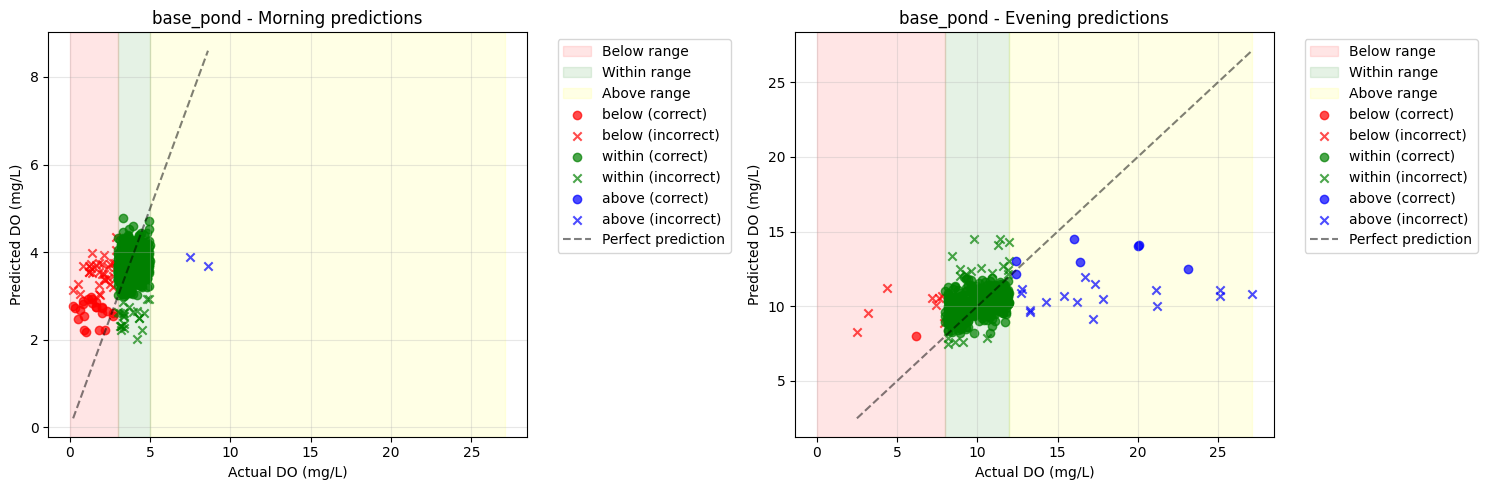

In [35]:
# Use the get_in_required_range function to classify DO measurements
from fwi_predict.wq import get_in_required_range
from fwi_predict.constants import WQ_RANGES
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score

# Iterate through each feature set's results
for name, result in results.items():
    print(f"\nAnalyzing {name} feature set...")
    
    # Get predictions and actual values
    y_test = result['results']['y_true'] 
    y_pred = result['results']['y_pred']
    time_of_day = winkler_df['morning'].apply(lambda x: 'morning' if x else 'evening') # Hacky

    actual_range = get_in_required_range('do_mg_per_L', y_test, time_of_day)
    predicted_range = get_in_required_range('do_mg_per_L', y_pred, time_of_day)

    # Calculate metrics for each range category
    categories = ['below', 'within', 'above']
    for category in categories:
        actual_mask = actual_range == category
        pred_mask = predicted_range == category
        
        if actual_mask.any():
            category_mse = mean_squared_error(y_test[actual_mask], y_pred[actual_mask])
            category_r2 = r2_score(y_test[actual_mask], y_pred[actual_mask])
            precision = precision_score(actual_range == category, predicted_range == category)
            recall = recall_score(actual_range == category, predicted_range == category)
            correct_class = (actual_range == predicted_range)[actual_mask].mean()
            
            print(f"\nMetrics for {category} range DO:")
            print(f"Number of samples: {actual_mask.sum()}")
            print(f"MSE: {category_mse:.3f}")
            print(f"R²: {category_r2:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"Classification accuracy: {correct_class:.1%}")

    # Visualize predictions
    plt.figure(figsize=(15, 5))
    colors = {'above': 'blue', 'within': 'green', 'below': 'red'}
    do_ranges = WQ_RANGES['do_mg_per_L']['required']

    for i, tod in enumerate(['morning', 'evening']):
        plt.subplot(1, 2, i+1)
        tod_mask = time_of_day == tod
        
        # Show prediction regions
        plt.axvspan(0, do_ranges[tod][0], alpha=0.1, color='red', label='Below range')
        plt.axvspan(do_ranges[tod][0], do_ranges[tod][1], alpha=0.1, color='green', label='Within range')
        plt.axvspan(do_ranges[tod][1], max(y_test.max(), y_pred.max()), 
                   alpha=0.1, color='yellow', label='Above range')
        
        # Plot points by category
        for category in categories:
            category_mask = tod_mask & (actual_range == category)
            correct_mask = category_mask & (actual_range == predicted_range)
            incorrect_mask = category_mask & (actual_range != predicted_range)
            
            plt.scatter(y_test[correct_mask], y_pred[correct_mask],
                       alpha=0.7, c=colors[category], marker='o',
                       label=f'{category} (correct)')
            plt.scatter(y_test[incorrect_mask], y_pred[incorrect_mask],
                       alpha=0.7, c=colors[category], marker='x',
                       label=f'{category} (incorrect)')

        # Add diagonal line
        plt.plot([y_test[tod_mask].min(), y_test[tod_mask].max()],
                 [y_test[tod_mask].min(), y_test[tod_mask].max()],
                 'k--', alpha=0.5, label='Perfect prediction')
        
        plt.xlabel('Actual DO (mg/L)')
        plt.ylabel('Predicted DO (mg/L)')
        plt.title(f'{name} - {tod.capitalize()} predictions')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
